<a href="https://colab.research.google.com/github/akshaypt7/amazon_sales_prediction/blob/main/my_project_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

In this notebook, we will first try out creating a very basic model with the data we have. This is done so that while trying to create a model, we will come across a lot of issues we would have to solve, we will note down these problems and address it in a new note book.

In [ ]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 23.3MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 1.2MB 43.8MB/s 
     |████████████████████████████████| 194kB 51.6MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
import pandas as pd

In [ ]:
import os
files = os.listdir('/content/gdrive/MyDrive/my_project_01')


39

### Reading files into Dataframes

In [ ]:
dict_files = {}
for i,file in enumerate(files):
  try:
    # dict_files[i] = pd.read_csv( '/content/drive/MyDrive/my_project_01/' +str(file),low_memory=False)
    dict_files[i] = pd.read_csv( '/content/gdrive/MyDrive/my_project_01/' +str(file),low_memory=False)
  except:
    # dict_files[i] = pd.read_excel( '/content/drive/MyDrive/my_project_01/' +str(file))
    dict_files[i] = pd.read_excel( '/content/gdrive/MyDrive/my_project_01/' +str(file))


Data Details-

We are removing all the columns that could create data leakage, like invoice number, transaction type, etc..because these data are only available when sales are made.

Here quantity is the dependent variable

The columns that we are keeping include : 


- Order Date
- Quantity
- Asin
- Principal Amount
- Item Promo Discount

##### Selecting columns



In [ ]:
df_dicts = {}

for i in range(len(dict_files)):
  df_dicts[i] = dict_files[i][['Order Date','Quantity','Asin','Principal Amount','Item Promo Discount']]


In [ ]:
dict_files[1].head()

,Seller Gstin,Invoice Number,Invoice Date,Transaction Type,...,Irn Number,Irn Filing Status,Irn Date,Irn Error Code
0,07CJVPA2317N1ZW,IN-SDEE-951,2021-02-01 17:34:28,Shipment,...,NaN,NaN,NaN,NaN
1,27CJVPA2317N1ZU,IN-BOM5-985,2021-02-04 09:24:18,Shipment,...,NaN,NaN,NaN,NaN
2,07CJVPA2317N1ZW,IN-SDEE-1000,2021-02-12 01:52:08,Shipment,...,NaN,NaN,NaN,NaN
3,07CJVPA2317N1ZW,IN-SDEE-1005,2021-02-13 10:36:09,Shipment,...,NaN,NaN,NaN,NaN
4,07CJVPA2317N1ZW,IN-SDEE-1006,2021-02-13 12:40:33,Shipment,...,NaN,NaN,NaN,NaN


In [ ]:
df_dicts[2].head()

,Order Date,Quantity,Asin,Principal Amount,Item Promo Discount
0,2020-12-28 15:41:42,1,B07TM3LRVB,1135,0.0
1,2020-12-25 18:50:21,1,B07TM3LRVB,1135,0.0
2,2020-12-28 23:01:59,1,B07TM3LRVB,1135,0.0
3,2020-12-23 10:27:16,1,B07TM3LRVB,1135,0.0
4,2020-12-18 11:41:24,1,B07TM3LRVB,1135,0.0


In [ ]:
dep_var = 'Quantity'

#### Converting the Order date into datetime format

In [ ]:
# concat all df
df = pd.DataFrame()
for i in range(len(df_dicts)):
  # we need to convert the Order date column into date_time
  if df_dicts[i]['Order Date'].dtype != 'datetime64[ns]' :
    df_copy = df_dicts[i].copy()

    df_copy['Order Date'] = pd.to_datetime(df_dicts[i]['Order Date'])

    df_dicts[i] = df_copy


  df = pd.concat([df , df_dicts[i]])


In [ ]:
df.dtypes

Order Date             datetime64[ns]
Quantity                        int64
Asin                           object
Principal Amount              float64
Item Promo Discount           float64
dtype: object

In [ ]:
df.head()

,Order Date,Quantity,Asin,Principal Amount,Item Promo Discount
0,2021-01-04 12:29:25,1,B07KYFHTGF,1995.0,0.00
1,2021-01-04 12:29:25,1,B07KYFHTGF,1995.0,0.00
2,2021-01-08 20:26:01,1,B07TM3LRVB,1135.0,-56.75
3,2021-01-09 22:11:09,1,B08976V1BZ,1599.0,-79.95
4,2021-01-11 10:24:45,1,B07TM3LRVB,1135.0,0.00


##### Adding hour of the day

During Purchases in amazon, the purchase time plays a major role.

In [ ]:
# Adding hour of the day
df['hour'] = df['Order Date'].dt.hour

In [ ]:
df.head()

,Order Date,Quantity,Asin,Principal Amount,Item Promo Discount,hour
0,2021-01-04 12:29:25,1,B07KYFHTGF,1995.0,0.00,12.0
1,2021-01-04 12:29:25,1,B07KYFHTGF,1995.0,0.00,12.0
2,2021-01-08 20:26:01,1,B07TM3LRVB,1135.0,-56.75,20.0
3,2021-01-09 22:11:09,1,B08976V1BZ,1599.0,-79.95,22.0
4,2021-01-11 10:24:45,1,B07TM3LRVB,1135.0,0.00,10.0


##### Adding date 

In [ ]:
# Adding day of the day
df['date'] = df['Order Date'].dt.date

In [ ]:
df.head()

,Order Date,Quantity,Asin,Principal Amount,Item Promo Discount,hour,date
0,2021-01-04 12:29:25,1,B07KYFHTGF,1995.0,0.00,12.0,2021-01-04
1,2021-01-04 12:29:25,1,B07KYFHTGF,1995.0,0.00,12.0,2021-01-04
2,2021-01-08 20:26:01,1,B07TM3LRVB,1135.0,-56.75,20.0,2021-01-08
3,2021-01-09 22:11:09,1,B08976V1BZ,1599.0,-79.95,22.0,2021-01-09
4,2021-01-11 10:24:45,1,B07TM3LRVB,1135.0,0.00,10.0,2021-01-11


##### We can try adding one more column later on whether there was discount or not            

#### Creating the final Dataframe

We creare the dataframe by grouping the below columns together.

In [ ]:
df_new = pd.DataFrame(df.groupby(['date','hour' ,'Asin','Principal Amount','Item Promo Discount'])['Quantity'].sum()).reset_index()

In [ ]:
df_new.head()

,date,hour,Asin,Principal Amount,Item Promo Discount,Quantity
0,2019-07-07,22.0,B07KYFHTGF,2099.0,0.0,1
1,2019-07-16,11.0,B07S8NC532,2099.0,0.0,1
2,2019-07-16,17.0,B07KYFHTGF,2099.0,0.0,1
3,2019-07-23,18.0,B07KYFHTGF,2099.0,0.0,1
4,2019-07-28,20.0,B07TM3LRVB,1295.0,0.0,1


In [ ]:
df_new.shape

(11199, 6)

##### Adding all the date information

In [ ]:
df_new = add_datepart(df_new,'date')

In [ ]:
df_new.columns

Index(['hour', 'Asin', 'Principal Amount', 'Item Promo Discount', 'Quantity',
       'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [ ]:
df_new.shape

(11199, 18)

#### Creating Tabular pandas

In [ ]:
dep_var = 'Quantity'

In [ ]:
procs = [Categorify, FillMissing]

cont_cat_split makes the split of the features based on the second para we give in, the number of levels

In [ ]:
cont, cat = cont_cat_split(df_new,1,dep_var= dep_var )

In [ ]:
cat

['Asin',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

##### We might have to change the continous and categorical variables, which we will do in the next notebook.

In [ ]:
cont

['hour',
 'Principal Amount',
 'Item Promo Discount',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Elapsed']

In [ ]:
# splits
max_date = max(df['date'])
min_date = min(df['date'])
max_date , min_date

# lets take 3 months

# the last date in feb 2021 so lets take dec 2020,jan and feb as the test set 
condition = (df_new.Year < 2020) | (df_new.Month < 12)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [ ]:
splits = (list(train_idx), list(valid_idx))

In [ ]:
df_new.columns

Index(['hour', 'Asin', 'Principal Amount', 'Item Promo Discount', 'Quantity',
       'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [ ]:
to = TabularPandas(df_new, procs = procs, cat_names = cat, cont_names = cont, y_names= dep_var, splits = splits)

In [ ]:
to.show(2)

,Asin,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,hour,Principal Amount,Item Promo Discount,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,Quantity
0,B07KYFHTGF,False,False,False,False,False,False,22.0,2099.0,0.0,2019,7,27,7,6,188,1.562458e+09,1
1,B07S8NC532,False,False,False,False,False,False,11.0,2099.0,0.0,2019,7,29,16,1,197,1.563235e+09,1


In [ ]:
to.items.head(2)

,hour,Asin,Principal Amount,Item Promo Discount,...,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,22.0,2,2099.0,0.0,...,1,1,1,1.562458e+09
1,11.0,6,2099.0,0.0,...,1,1,1,1.563235e+09


##### Saving the Tabular Pandas

In [ ]:
# save_pickle('/content/gdrive/MyDrive/bluebook/to.pkl',to)

In [ ]:

import pickle

In [ ]:
file = open('/content/gdrive/MyDrive/bluebook/to.pkl', 'rb')

# dump information to that file
to = pickle.load(file)

# close the file
file.close()

In [ ]:
to.show(2)

,Asin,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,hour,Principal Amount,Item Promo Discount,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,Quantity
0,B07KYFHTGF,False,False,False,False,False,False,22.0,2099.0,0.0,2019,7,27,7,6,188,1.562458e+09,1
1,B07S8NC532,False,False,False,False,False,False,11.0,2099.0,0.0,2019,7,29,16,1,197,1.563235e+09,1


#### Train and test set

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
xs.shape, valid_xs.shape

((10520, 17), (679, 17))

### Root Mean Sqaure Error

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.870206, 0.748436)

### Random Forest

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=2000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
# Creating RandomForestClassifier
def rf_classify(xs, y, n_estimators=40, max_samples=2000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m_classify = rf_classify(xs,y)

In [ ]:
m_rmse(m_classify, xs, y), m_rmse(m_classify, valid_xs, valid_y)

(0.705087, 0.827545)

#### How the predictions look like

In [ ]:
m_classify.predict(valid_xs)

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
     

In [ ]:
valid_y

7370     1
7371     1
7372     1
7373     1
7374     1
        ..
11194    1
11195    1
11196    1
11197    1
11198    1
Name: Quantity, Length: 679, dtype: int8

In [ ]:
m = rf(xs, y);

##### M_RMSE of the model

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.870171, 0.724714)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
r_mse(preds.mean(0), valid_y)

0.724714

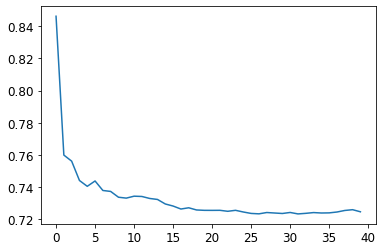

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [ ]:
r_mse(m.oob_prediction_, y)

0.910529

#### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
8,Principal Amount,0.301418
7,hour,0.139414
16,Elapsed,0.122433
15,Dayofyear,0.115888
13,Day,0.093677
0,Asin,0.065416
14,Dayofweek,0.064194
12,Week,0.058535
11,Month,0.018391
9,Item Promo Discount,0.011592


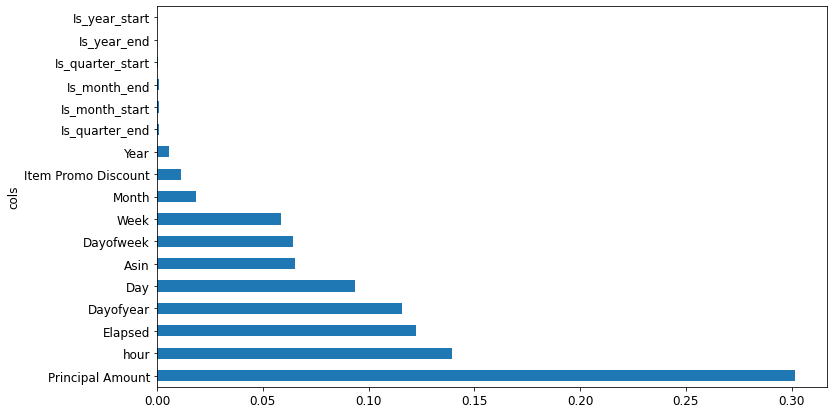

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

##### Looking at the get predictions

We try to work by chaning the Threshold. lets see what will happen when we say that above 1.4 can be considered as 2 and above 2.4 as 3

In [ ]:
predictions = m.predict(valid_xs)



array([1.1300496 , 1.14819444, 1.53545184, 1.57196429, 1.3169219 , 1.71105159, 1.67456349, 2.28889881, 1.60021825, 1.33059343])

In [ ]:
new_predictions = np.rint(predictions)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m.predict(xs)

array([1.43736201, 1.3419246 , 1.26100379, ..., 1.29860841, 1.1625947 , 1.38383256])

In [ ]:
m_rmse(m, valid_xs,valid_y)

0.724714

In [ ]:
r_mse(new_predictions,valid_y)

0.819497

#### Looking at Redundant Features

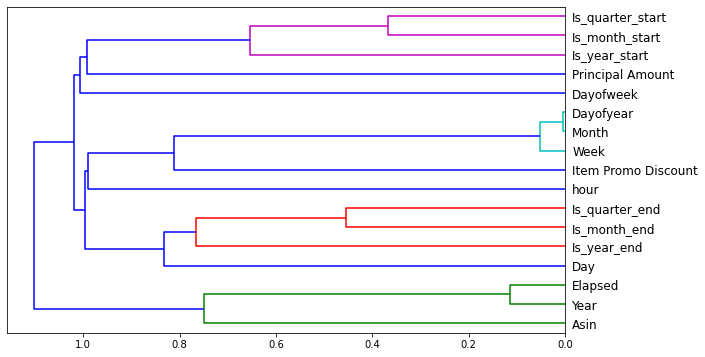

In [ ]:
cluster_columns(xs)